In [1]:
import pandas as pd
import numpy as np

In [ ]:
REMOVER_path = "../data/raw/REMOVER.xlsx"

In [3]:
df_REMOVER = pd.read_excel(REMOVER_path, sheet_name=0)

df_REMOVER

,ID,LATITUDE (°) - tide free,LONGITUDE (°) - tide free,H (m) - zero tide,Anomalia de gravidade de Helmert (mGal) - zero tide,Anomalia de gravidade GOCO06s até 300 (mGal),Efeito indireto em Anomalia de gravidade de Helmert (mGal),Anomalia de gravidade residual (mGal)
0,1,-25.516756,-49.119866,901.0751,64.517168,41.4012,-0.002100,23.113868
1,2,-25.547078,-49.049065,919.3276,67.387901,36.1392,-0.002500,31.248701
2,3,-25.491400,-48.996752,961.0942,74.774243,31.8169,-0.002300,42.957343
3,4,-25.438241,-49.014173,935.6272,68.184230,32.9337,-0.003500,35.250530
4,5,-25.439573,-49.099058,882.9281,68.304470,39.3425,-0.002000,28.961970
...,...,...,...,...,...,...,...,...
30027,30028,-22.780000,-48.610000,810.9000,1.014528,-13.2664,-0.000023,14.280928
30028,30029,-24.240000,-48.590000,863.1000,38.928398,13.9987,-0.009798,24.929698
30029,30030,-22.735000,-48.570000,686.1000,-11.366440,-12.8696,-0.009911,1.503160
30030,30031,-23.931700,-48.533300,641.0000,-2.859735,-0.1051,-0.011099,-2.754635


In [4]:
# df_REMOVER já está carregado
colmap = {
    'LATITUDE (°) - tide free': 'lat',
    'LONGITUDE (°) - tide free': 'lon',
    'H (m) - zero tide': 'H_zerotide_m',
    'Anomalia de gravidade de Helmert (mGal) - zero tide': 'dg_helmert_mgal',
    'Anomalia de gravidade GOCO06s até 300 (mGal)': 'dg_goco_mgal',
    'Efeito indireto em Anomalia de gravidade de Helmert (mGal)': 'dg_indirect_mgal',
    'Anomalia de gravidade residual (mGal)': 'dg_residual_planilha_mgal',
}
df = df_REMOVER.rename(columns=colmap).copy()


# ordenar colunas de interesse
df = df[['lat','lon','H_zerotide_m','dg_helmert_mgal','dg_goco_mgal','dg_indirect_mgal','dg_residual_planilha_mgal']]
len(df), df.head(3)

(30032,
          lat        lon  H_zerotide_m  dg_helmert_mgal  dg_goco_mgal  \
 0 -25.516756 -49.119866      901.0751        64.517168       41.4012   
 1 -25.547078 -49.049065      919.3276        67.387901       36.1392   
 2 -25.491400 -48.996752      961.0942        74.774243       31.8169   
 
    dg_indirect_mgal  dg_residual_planilha_mgal  
 0           -0.0021                  23.113868  
 1           -0.0025                  31.248701  
 2           -0.0023                  42.957343  )

### Recalcular a anomalia residual e checar contra a planilha

Fórmula:

$$
\Delta g_{\text{res}}=\Delta g_{\text{Helmert}}-\Delta g_{\text{GOCO06s}}-\delta_{\text{indireto}}
$$

In [5]:
df['dg_res_calc_mgal'] = (
    df['dg_helmert_mgal']
    - df['dg_goco_mgal']
    - df['dg_indirect_mgal']
)

df['erro_mgal'] = df['dg_res_calc_mgal'] - df['dg_residual_planilha_mgal']

print(df[['dg_res_calc_mgal','dg_residual_planilha_mgal','erro_mgal']].head())
print(
    f"Erro abs. máx = {df['erro_mgal'].abs().max():.6f} mGal | "
    f"RMSE = {np.sqrt((df['erro_mgal']**2).mean()):.6f} mGal"
)


   dg_res_calc_mgal  dg_residual_planilha_mgal  erro_mgal
0         23.118068                  23.113868     0.0042
1         31.251201                  31.248701     0.0025
2         42.959643                  42.957343     0.0023
3         35.254030                  35.250530     0.0035
4         28.963970                  28.961970     0.0020
Erro abs. máx = 0.040113 mGal | RMSE = 0.010563 mGal


In [6]:
# tirar linhas com NaN nas colunas essenciais
keep = ['lat','lon','dg_res_calc_mgal']
clean = df.dropna(subset=keep).copy()

# salvar um CSV "canônico" para a próxima etapa
clean.to_csv("../REMOVER/remove_pontos.csv", index=False)

# opcional: também salvar um TXT sem cabeçalho (se quiser reproduzir formato de scripts antigos)
clean[['lat','lon','dg_res_calc_mgal']].to_csv(
    "../REMOVER/remove_pontos.txt",
    index=False, header=False, float_format="%.6f"
)

len(clean), clean.head(3)


(30032,
          lat        lon  H_zerotide_m  dg_helmert_mgal  dg_goco_mgal  \
 0 -25.516756 -49.119866      901.0751        64.517168       41.4012   
 1 -25.547078 -49.049065      919.3276        67.387901       36.1392   
 2 -25.491400 -48.996752      961.0942        74.774243       31.8169   
 
    dg_indirect_mgal  dg_residual_planilha_mgal  dg_res_calc_mgal  erro_mgal  
 0           -0.0021                  23.113868         23.118068     0.0042  
 1           -0.0025                  31.248701         31.251201     0.0025  
 2           -0.0023                  42.957343         42.959643     0.0023  )

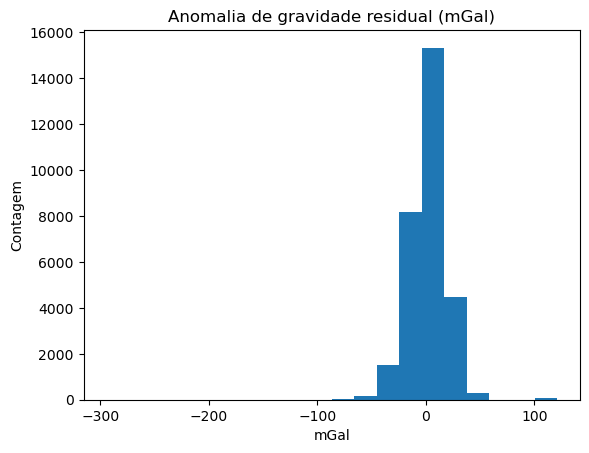

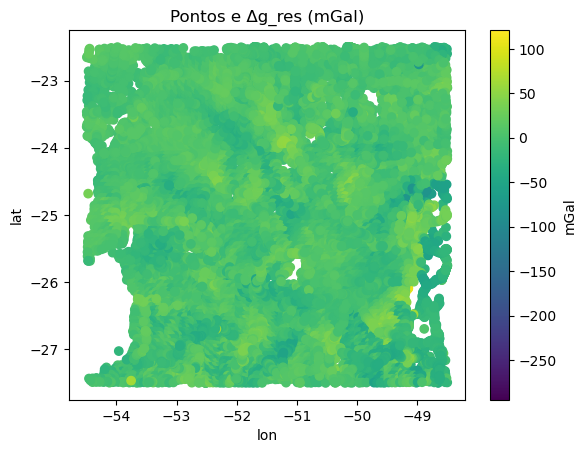

In [7]:
import matplotlib.pyplot as plt

plt.hist(clean['dg_res_calc_mgal'], bins=20)
plt.title("Anomalia de gravidade residual (mGal)")
plt.xlabel("mGal"); plt.ylabel("Contagem")
plt.show()

plt.scatter(clean['lon'], clean['lat'], c=clean['dg_res_calc_mgal'])
plt.title("Pontos e Δg_res (mGal)")
plt.xlabel("lon"); plt.ylabel("lat")
plt.colorbar(label="mGal")
plt.show()
